## EHR Diabetes Analysis and Predicition 

In [1]:
# First we load the libraries we will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import shap 
import shap


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Here we load the data and begin to explore and clean it 
Diabetes_df = pd.read_csv('/Users/danielharrod/Medical_Data_Projects/Medical_Data_Projects/Healthcare_CSV/Healthcare-Diabetes.csv')

# Check the df
Diabetes_df.head()


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [51]:
# Check for missing values
print(Diabetes_df.isnull().sum())

Id                          0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [52]:
# List of columns where zero might indicate missing values
cols_with_possible_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Check the number of zeros in each column
for col in cols_with_possible_missing:
    zero_count = (Diabetes_df[col] == 0).sum()
    print(f'Number of zeros in {col}: {zero_count}')


Number of zeros in Glucose: 18
Number of zeros in BloodPressure: 125
Number of zeros in SkinThickness: 800
Number of zeros in Insulin: 1330
Number of zeros in BMI: 39


In [53]:
# Replace zeros with NaN in specific columns
for col in cols_with_possible_missing:
    Diabetes_df[col] = Diabetes_df[col].replace(0, np.nan)

# Confirm the changes
print(Diabetes_df[cols_with_possible_missing].isnull().sum())

Glucose            18
BloodPressure     125
SkinThickness     800
Insulin          1330
BMI                39
dtype: int64


In [54]:
# Impute missing values with the median of each column
for col in cols_with_possible_missing:
    Diabetes_df[col].fillna(Diabetes_df[col].median(), inplace=True)


# Exploritory Data Analysis (EDA)


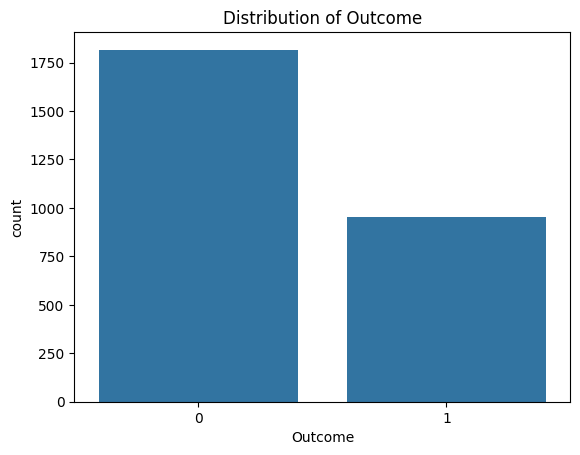

                  Id  Pregnancies     Glucose  BloodPressure  SkinThickness  \
Outcome                                                                       
0        1388.143722     3.204295  111.063877      70.894824      27.850220   
1        1377.549370     4.769958  142.464286      75.230042      31.792017   

            Insulin        BMI  DiabetesPedigreeFunction        Age  
Outcome                                                              
0        128.704846  31.101597                  0.433316  31.111233  
1        163.493697  35.440546                  0.543445  36.987395  


In [55]:
# Countplot of Outcome variable
sns.countplot(x='Outcome', data=Diabetes_df)
plt.title('Distribution of Outcome')
plt.show()

# Grouped statistics
print(Diabetes_df.groupby('Outcome').mean())



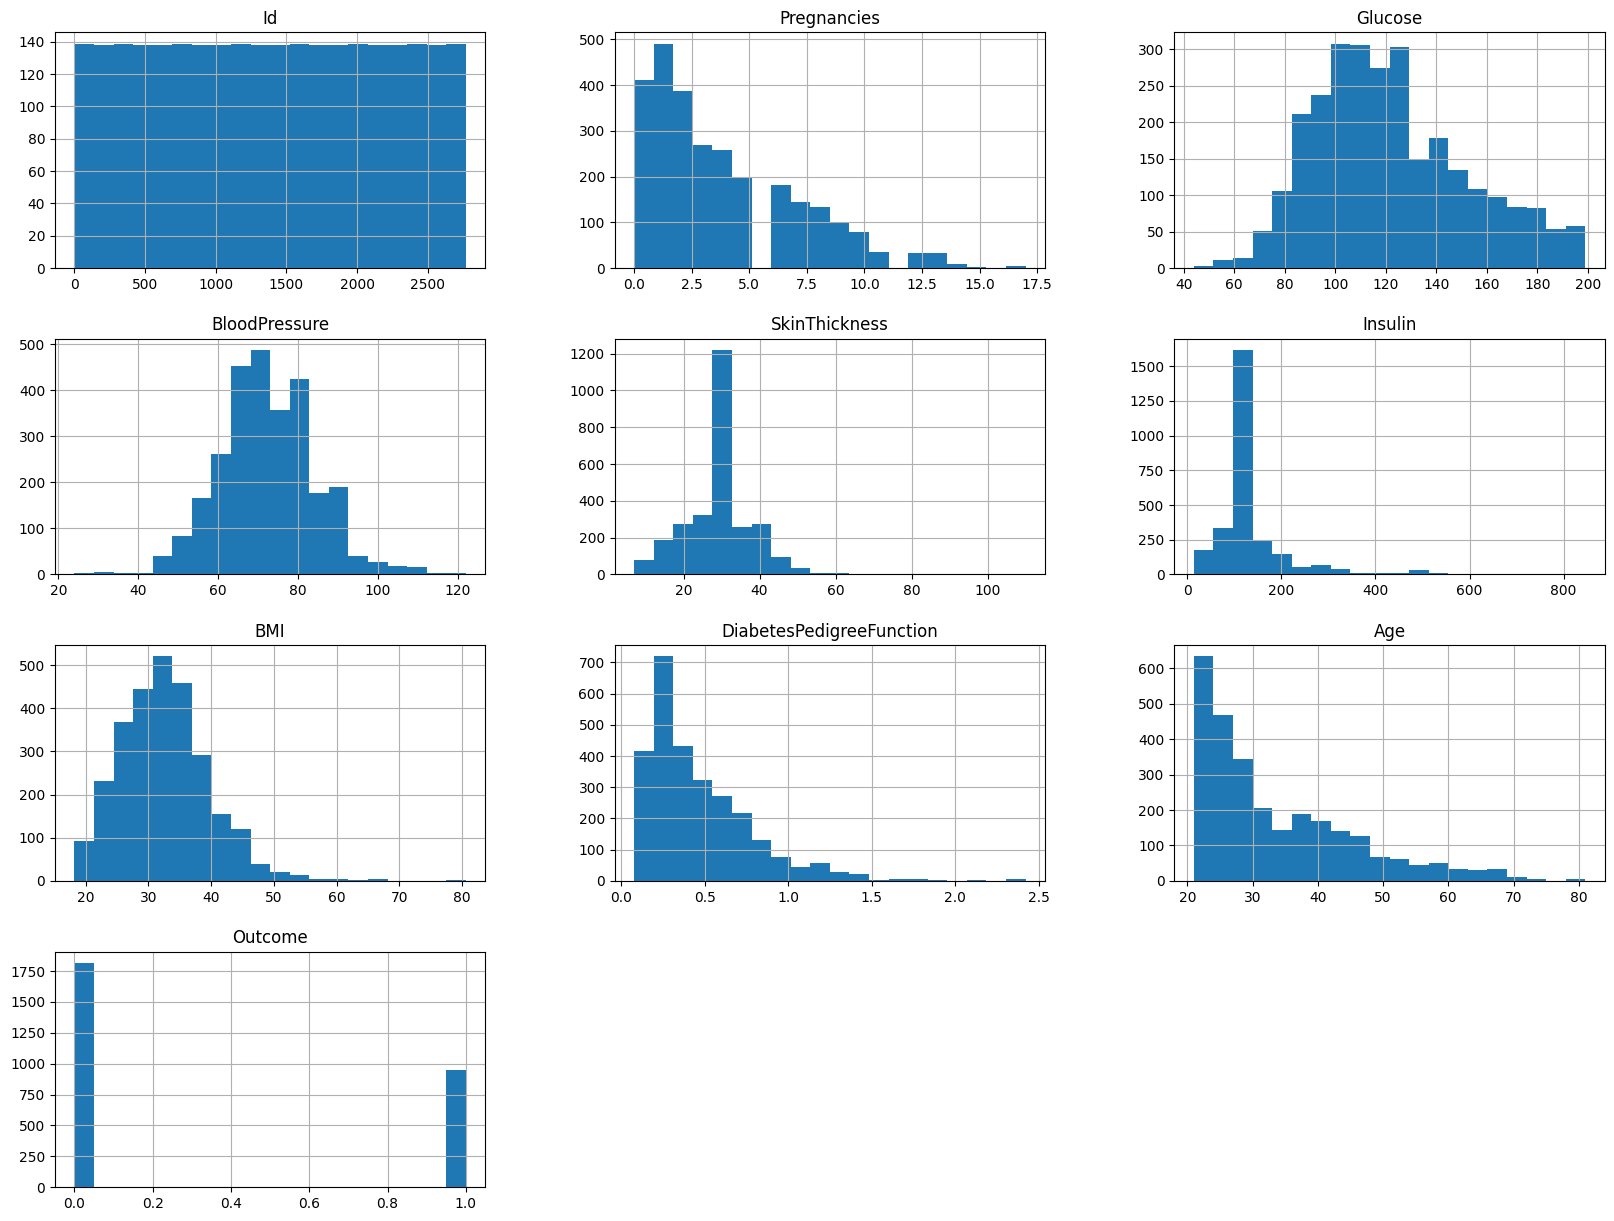

In [56]:
# Histograms
Diabetes_df.hist(bins=20, figsize=(20,15))
plt.show()


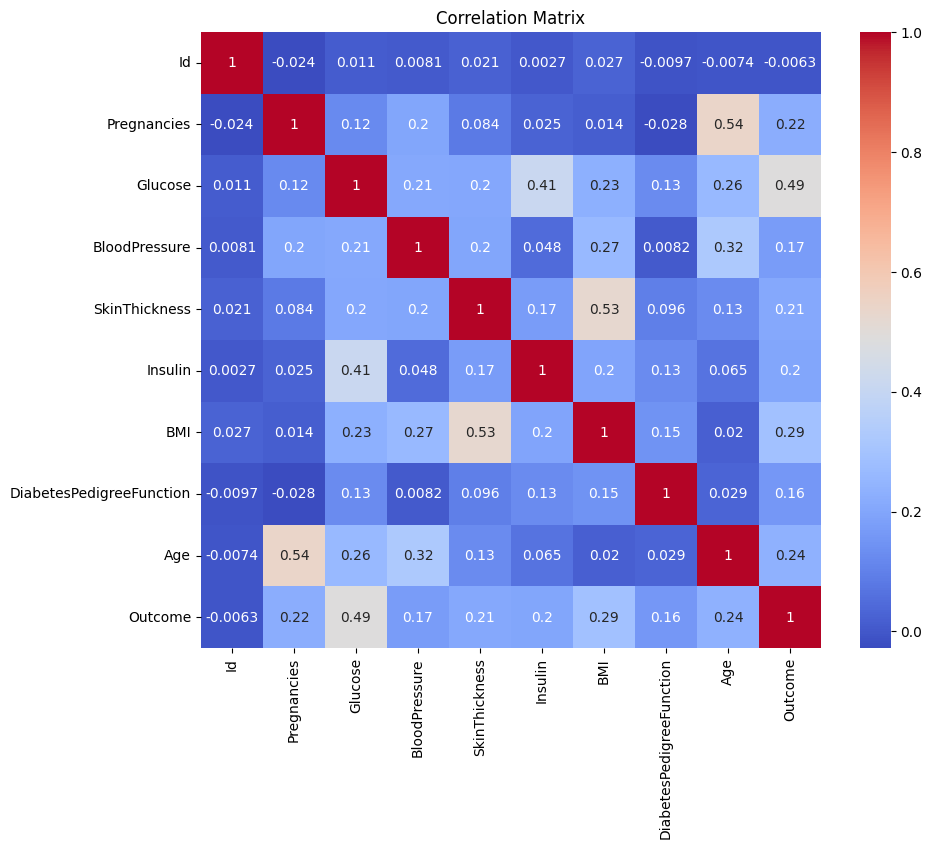

In [57]:
# Compute correlation matrix
corr_matrix = Diabetes_df.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


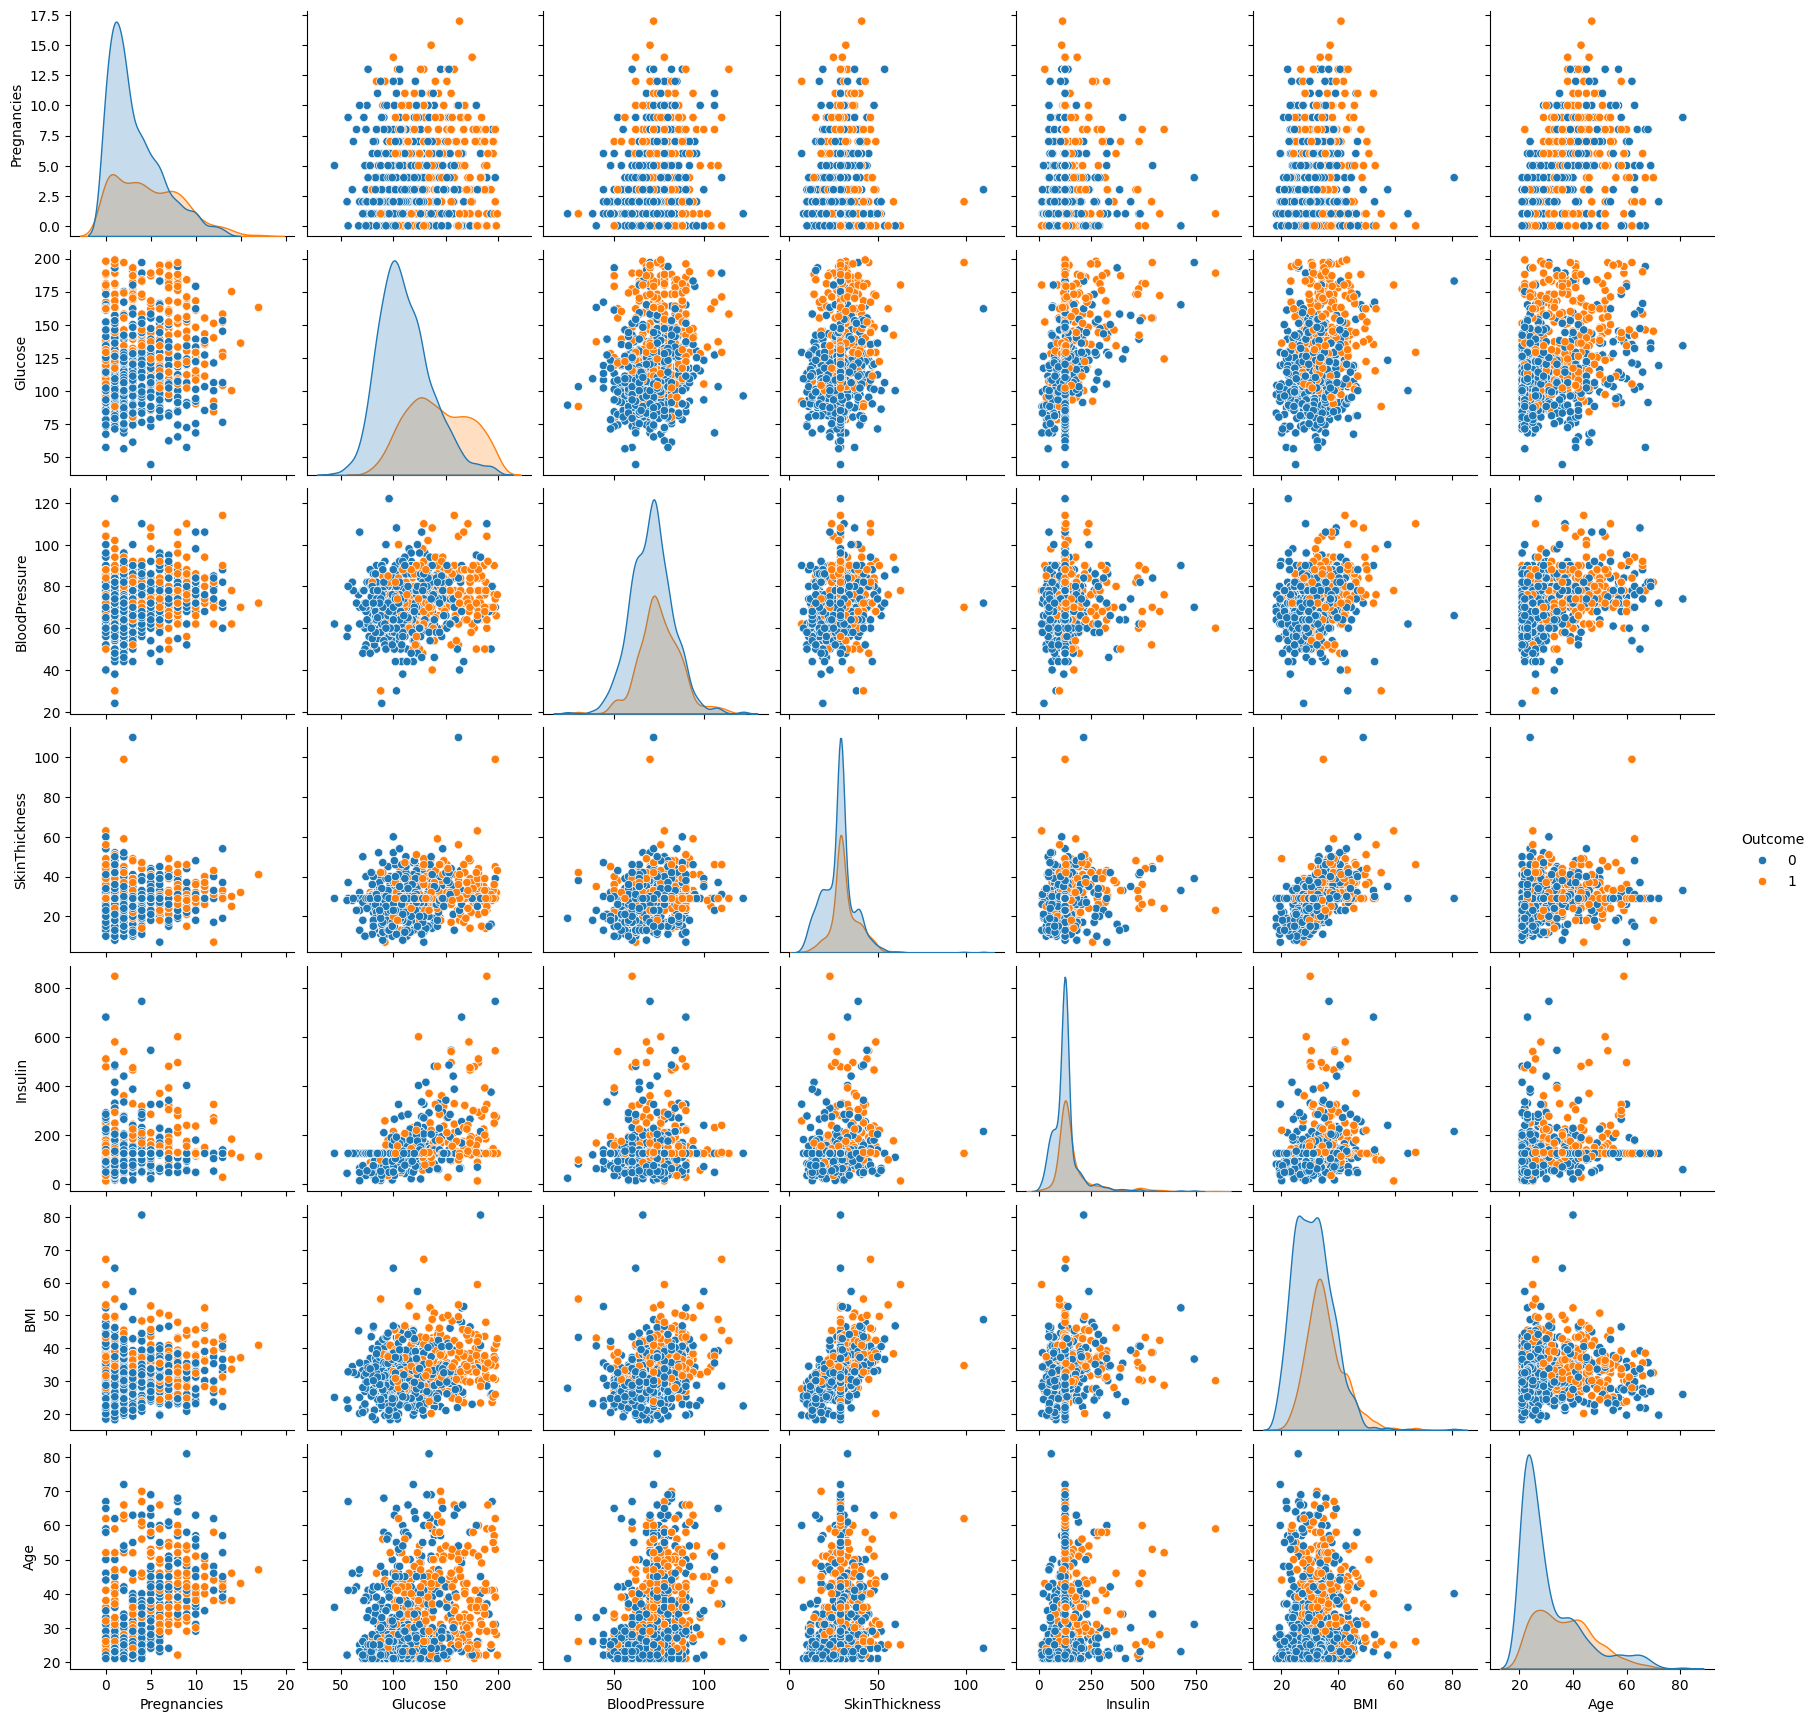

In [58]:
# Pairplot of features colored by Outcome
sns.pairplot(Diabetes_df, hue='Outcome', vars=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age'])
plt.show()


## Data Preparation For Modeling 


In [59]:
# Feature 1 selection target value and features
X = Diabetes_df.drop('Outcome', axis=1)
y = Diabetes_df['Outcome']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       363
           1       0.68      0.54      0.61       191

    accuracy                           0.76       554
   macro avg       0.73      0.71      0.71       554
weighted avg       0.75      0.76      0.75       554



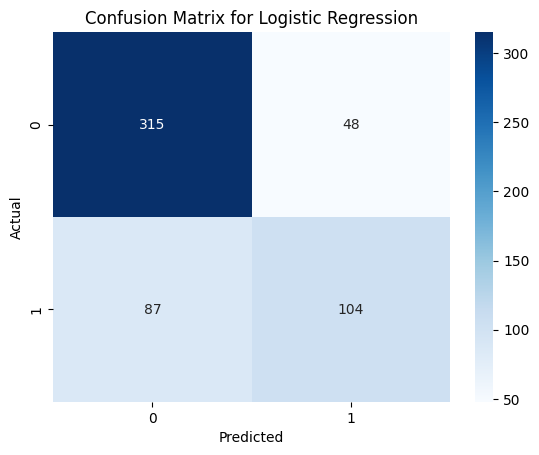

In [60]:
# Logistical regression 

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       363
           1       0.98      0.98      0.98       191

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554



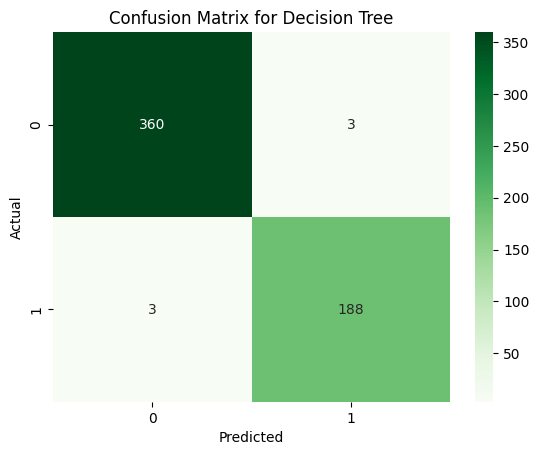

In [61]:
# Decision Tree Classifier 

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# Predictions
y_pred_dtree = dtree.predict(X_test)

# Evaluation
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dtree))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dtree)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       363
           1       1.00      0.99      0.99       191

    accuracy                           1.00       554
   macro avg       1.00      0.99      1.00       554
weighted avg       1.00      1.00      1.00       554



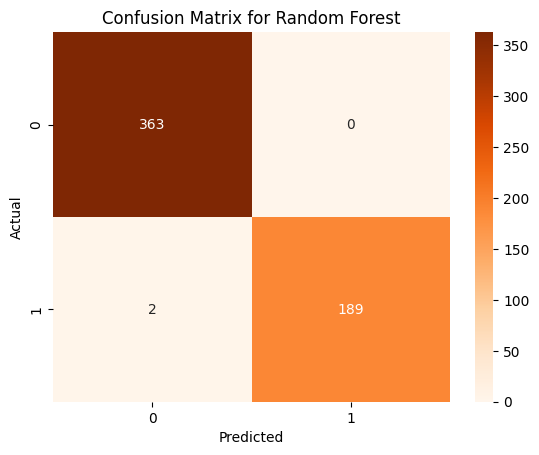

In [62]:
# Randoim Forest Classifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix for Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## Model Evaluation: ROC Curve and AUC


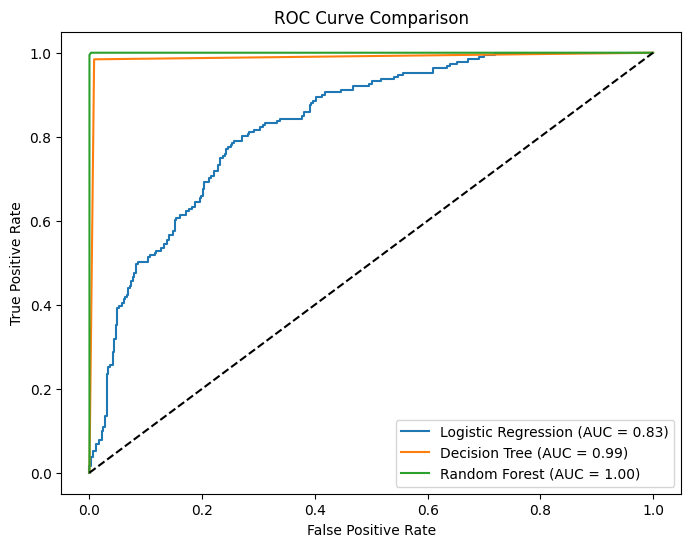

In [63]:
# Plot ROC Curve for all models
models = [logreg, dtree, rf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

plt.figure(figsize=(8,6))

for model, name in zip(models, model_names):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0,1], [0,1], 'k--')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

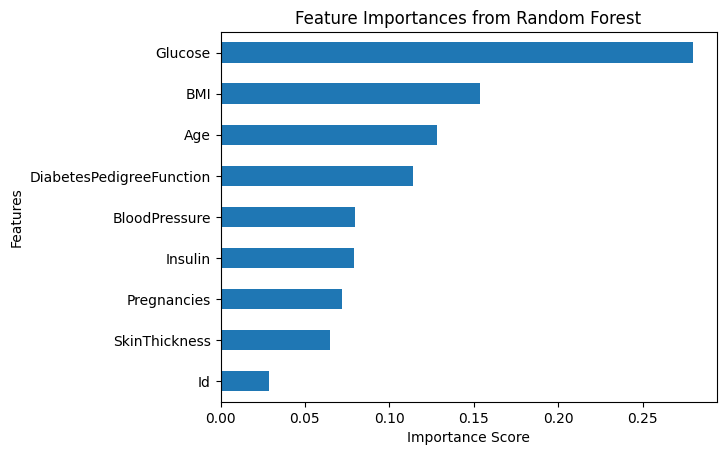

In [64]:
# Feature Imporance for Random Forrest Classifier# Feature importance for Random Forest
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [65]:
from sklearn.model_selection import GridSearchCV

# Parameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Best estimator
best_rf = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_best_rf = best_rf.predict(X_test)
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))


Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       363
           1       1.00      0.99      0.99       191

    accuracy                           1.00       554
   macro avg       1.00      0.99      1.00       554
weighted avg       1.00      1.00      1.00       554



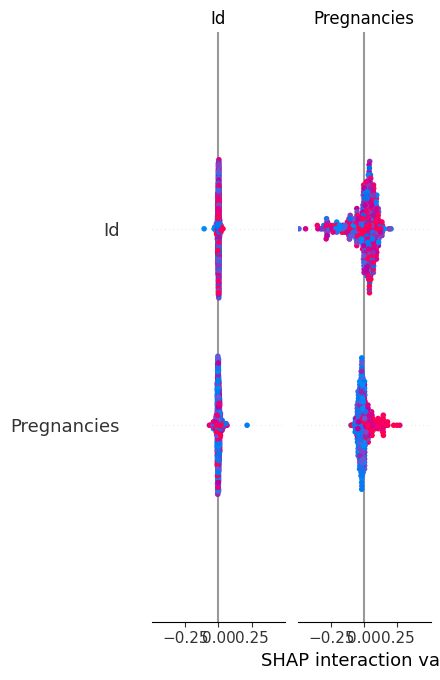

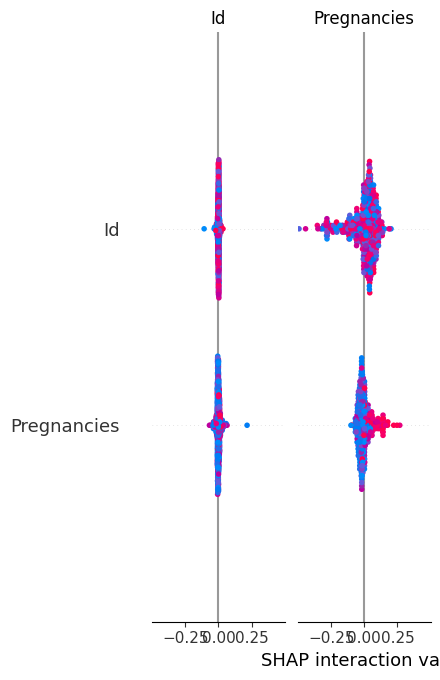

In [87]:
# Initialize the JavaScript visualization code (for notebooks)
shap.initjs()



# Assuming X_train and X_test are your training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled test data to DataFrame with feature names
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Create the SHAP explainer using your trained model 'rf'
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for the test set using the scaled data
shap_values = explainer.shap_values(X_test_df)

# Handle the SHAP values based on their type (list or array)
# For binary classification, shap_values may be a list of arrays
if isinstance(shap_values, list):
    # Select the SHAP values for the positive class (assuming '1' is positive)
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

# Generate the SHAP summary plot with adjusted plot size
shap.summary_plot(shap_values_class1, X_test_df, plot_size=(12, 8))

# Generate the SHAP feature importance bar plot with adjusted plot size
shap.summary_plot(shap_values_class1, X_test_df, plot_type="bar", plot_size=(12, 8))








In [71]:
# Verify shapes of X_test and X_test_df
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of X_test_df: {X_test_df.shape}")

# Verify shape of shap_values before selecting shap_values_class1
print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Length of shap_values list: {len(shap_values)}")
    print(f"Shape of shap_values[0]: {shap_values[0].shape}")
    print(f"Shape of shap_values[1]: {shap_values[1].shape}")
else:
    print(f"Shape of shap_values: {shap_values.shape}")


Shape of X_test: (554, 9)
Shape of X_test_df: (554, 9)
Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (554, 9, 2)


In [69]:
# Assuming '1' is the positive class (diabetes present)
shap_values_class1 = shap_values[:, :, 1]  # Select SHAP values for class 1

# Verify shapes
print(f"Shape of shap_values_class1: {shap_values_class1.shape}")
print(f"Shape of X_test_df: {X_test_df.shape}")


Shape of shap_values_class1: (554, 9)
Shape of X_test_df: (554, 9)
